In [409]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import scipy.linalg
import time
import torch
import warp as wp
import open3d as o3d

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from example_sim_neo_hookean import Example

Warp 0.8.0 initialized:
   CUDA Toolkit: 11.5, Driver: 11.4
   Devices:
     "cpu"    | x86_64
     "cuda:0" | Quadro P4000 (sm_61)
   Kernel cache: /home/motion/.cache/warp/0.8.0


In [3]:
stage_path = os.path.join("outputs/example_sim_neo_hookean.usd")

example = Example(stage_path)

In [4]:
for i in range(example.sim_frames):
    example.update()

    curr_state = example.state_0
    curr_particle_q = curr_state.particle_q.numpy()

    # if i % 20 == 0:
    #     pcd = o3d.geometry.PointCloud()
    #     pcd.points = o3d.utility.Vector3dVector(curr_particle_q)
    #     o3d.visualization.draw_geometries([pcd])

	Module example_sim_neo_hookean load on device 'cuda:0' took 1.57 ms
	Module warp.sim.integrator_euler load on device 'cuda:0' took 47.92 ms
simulate took 57.01 ms
simulate took 6.64 ms
simulate took 6.37 ms
simulate took 6.53 ms
simulate took 6.58 ms
simulate took 6.56 ms
simulate took 6.25 ms
simulate took 6.21 ms
simulate took 6.12 ms
simulate took 6.23 ms
simulate took 6.24 ms
simulate took 6.22 ms
simulate took 6.31 ms
simulate took 6.26 ms
simulate took 6.16 ms
simulate took 6.53 ms
simulate took 6.19 ms
simulate took 6.37 ms
simulate took 6.20 ms
simulate took 6.10 ms
simulate took 6.03 ms
simulate took 6.10 ms
simulate took 7.14 ms
simulate took 8.49 ms
simulate took 6.32 ms
simulate took 6.21 ms
simulate took 7.98 ms
simulate took 9.38 ms
simulate took 6.48 ms
simulate took 6.29 ms
simulate took 6.24 ms
simulate took 6.11 ms
simulate took 6.17 ms
simulate took 6.48 ms
simulate took 7.20 ms
simulate took 6.10 ms
simulate took 6.08 ms
simulate took 6.49 ms
simulate took 6.12 ms


### Example to load mesh models

In [ ]:
from warp.sim.model import Mesh

# load triangle mesh
o3d_mesh = o3d.io.read_triangle_mesh("assets/rest_mesh.stl")

verts = np.array(o3d_mesh.vertices)
faces = np.array(o3d_mesh.triangles)

wp_mesh = Mesh(verts, faces.reshape(-1))

### Example to compute material parameters gradient

In [410]:
from warp.sim.integrator_euler import compute_forces, eval_tetrahedra

In [51]:
from example_sim_grid_deform import eval_linear_tetrahedra

In [455]:
time_id = 1684514077

In [445]:
particle_q_init = np.load(f'outputs/box_deform_{time_id}/particle_q_init.npy')
particle_f_init = np.load(f'outputs/box_deform_{time_id}/particle_f_init.npy')

In [456]:
particle_q_lst = []
particle_v_lst = []
particle_f_lst = []

for idx in range(300):
    x = np.load(f'outputs/box_deform_{time_id}/particle_q_{idx}.npy')
    particle_q_lst.append(x)

    v = np.load(f'outputs/box_deform_{time_id}/particle_qd_{idx}.npy')
    particle_v_lst.append(v)

    f = np.load(f'outputs/box_deform_{time_id}/particle_f_{idx}.npy')
    particle_f_lst.append(f)

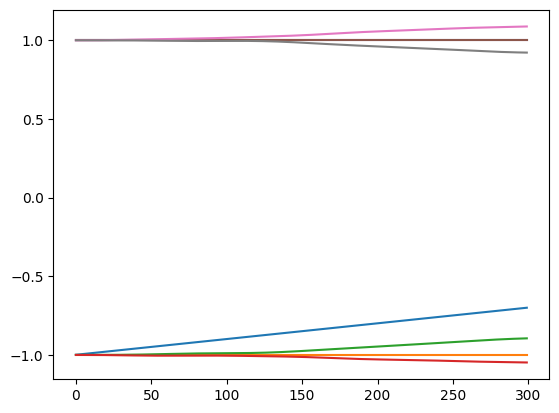

In [457]:
for idx in range(8):
    plt.plot([x[idx, 2] for x in particle_q_lst])
plt.show()

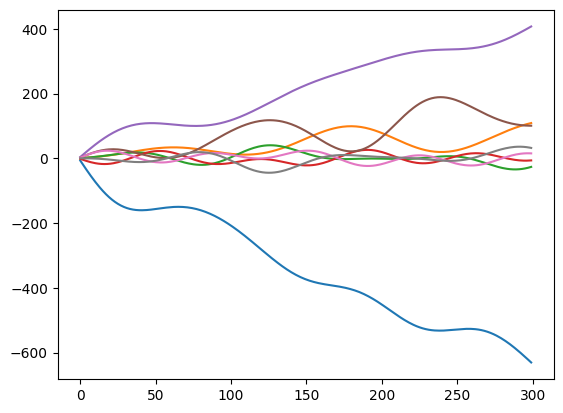

In [458]:
for idx in range(8):
    plt.plot([f[idx, 2] for f in particle_f_lst])
plt.show()

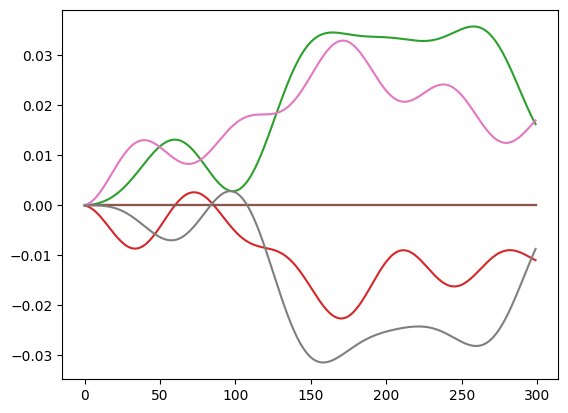

In [459]:
for idx in range(8):
    plt.plot([v[idx, 2] for v in particle_v_lst])
plt.show()

In [400]:
builder = wp.sim.ModelBuilder()

cell_dim = 1
cell_size = 2.0 / cell_dim

center = cell_size * cell_dim * 0.5

builder.add_soft_grid(
    pos=(-center, 0.0, -center),
    rot=wp.quat_identity(),
    vel=(0.0, 0.0, 0.0),
    dim_x=cell_dim,
    dim_y=cell_dim,
    dim_z=cell_dim,
    cell_x=cell_size,
    cell_y=cell_size,
    cell_z=cell_size,
    density=100.0,
    fix_bottom=True,
    fix_top=True,
    k_mu=100.0,
    k_lambda=5000.0,
    k_damp=0.0,
)

model = builder.finalize()
model.ground = False
model.gravity[1] = 0.0

In [401]:
@wp.kernel
def loss_l2(ary1: wp.array(dtype=wp.vec3f), ary2: wp.array(dtype=wp.vec3f), loss: wp.array(dtype=wp.float32)):
    i = wp.tid()
    diff = ary1[i] - ary2[i]
    l = wp.dot(diff, diff)
    wp.atomic_add(loss, 0, l)

In [407]:
from generic_adam import Adam

In [403]:
for _ in range(2000):
    state = model.state()
    state.particle_q = wp.from_numpy(particle_q_lst[100], dtype=wp.vec3f, device='cuda', requires_grad=True)
    particle_f = wp.zeros(shape=state.particle_f.shape, dtype=state.particle_f.dtype, 
                        device='cuda', requires_grad=True)
    model.tet_materials.requires_grad = True

    tape = wp.Tape()

    with tape:
        wp.launch(
            kernel=eval_linear_tetrahedra,
            dim=model.tet_count,
            inputs=[
                state.particle_q,
                model.tet_indices,
                model.tet_poses,
                model.tet_materials,
            ],
            outputs=[particle_f],
            device=model.device,
        )
        loss = wp.zeros(1, dtype=wp.float32, device='cuda', requires_grad=True)
        target_f = wp.from_numpy(particle_f_lst[100], dtype=wp.vec3f, device='cuda')
        wp.launch(loss_l2, dim=len(particle_f), inputs=[particle_f, target_f], outputs=[loss])

    tape.backward(loss)
    print("loss value:", loss.numpy())

    m = model.tet_materials.numpy()
    m_grad = model.tet_materials.grad.numpy()
    m = m - m_grad * 1e-2
    model.tet_materials = wp.from_numpy(m, dtype=wp.float32, device='cuda', requires_grad=True)

    tape.zero()

Module __main__ load on device 'cuda:0' took 9.99 ms
loss value: [35840008.]
loss value: [17793102.]
loss value: [10740442.]
loss value: [7113862.5]
loss value: [5013775.5]
loss value: [3711158.5]
loss value: [2869302.2]
loss value: [2308845.8]
loss value: [1925398.6]
loss value: [1655258.]
loss value: [1458600.8]
loss value: [1310246.1]
loss value: [1194111.8]
loss value: [1099878.4]
loss value: [1020853.]
loss value: [952693.]
loss value: [892519.]
loss value: [838434.06]
loss value: [789144.]
loss value: [743757.6]
loss value: [701659.]
loss value: [662395.75]
loss value: [625631.4]
loss value: [591115.8]
loss value: [558641.3]
loss value: [528048.4]
loss value: [499194.8]
loss value: [471961.22]
loss value: [446246.75]
loss value: [421954.2]
loss value: [398999.25]
loss value: [377304.66]
loss value: [356797.97]
loss value: [337408.3]
loss value: [319078.56]
loss value: [301746.72]
loss value: [285359.34]
loss value: [269861.72]
loss value: [255208.6]
loss value: [241351.25]
loss v

In [404]:
model.tet_materials.numpy()

array([[ 999.99896, 5000.001  ,    0.     ],
       [ 999.9989 , 5000.001  ,    0.     ],
       [ 999.9999 , 5000.0005 ,    0.     ],
       [ 999.99963, 5000.0005 ,    0.     ],
       [1000.0007 , 4999.9995 ,    0.     ]], dtype=float32)

In [34]:
wp.launch(
    kernel=eval_linear_tetrahedra,
    dim=model.tet_count,
    inputs=[
        state.particle_q,
        model.tet_indices,
        model.tet_poses,
        model.tet_materials,
    ],
    outputs=[particle_f],
    device=model.device,
)

Module __main__ load on device 'cuda:0' took 804.96 ms


In [68]:
particle_f.numpy()

array([[ 17337.469,  17596.295,  17510.676],
       [ -9582.57 ,   9681.48 ,   9524.835],
       [  9482.57 ,  -9614.814,   9424.835],
       [-17170.803, -17662.96 ,  17344.008],
       [  9582.57 ,   9681.48 ,  -9524.835],
       [-17337.469,  17596.293, -17510.676],
       [ 17170.803, -17662.96 , -17344.008],
       [ -9482.57 ,  -9614.814,  -9424.835]], dtype=float32)

In [69]:
target_f.numpy()

array([[ 16708.047,  19296.295,  18440.098],
       [ -9992.378,  10981.48 ,   9415.027],
       [  8992.378, -10314.814,   8415.027],
       [-15041.379, -19962.96 ,  16773.43 ],
       [  9992.378,  10981.48 ,  -9415.027],
       [-16708.047,  19296.295, -18440.096],
       [ 15041.379, -19962.96 , -16773.43 ],
       [ -8992.378, -10314.814,  -8415.027]], dtype=float32)

In [70]:
keys = list(tape.gradients.keys())
values = list(tape.gradients.values())

In [80]:
keys[3].numpy()

array([[ 100., 5000.,    0.],
       [ 100., 5000.,    0.],
       [ 100., 5000.,    0.],
       [ 100., 5000.,    0.],
       [ 100., 5000.,    0.]], dtype=float32)

In [81]:
values[3].numpy()

array([[ -9933.334 , -16022.213 ,      0.    ],
       [ -9933.332 , -16022.221 ,      0.    ],
       [-13800.002 ,   6866.6733,      0.    ],
       [-13800.004 ,   6866.6655,      0.    ],
       [-32177.781 , -10074.061 ,      0.    ]], dtype=float32)

In [425]:
@wp.kernel
def move_points(
    move_i: wp.array(dtype=int), move_u: wp.array(dtype=wp.vec3), points: wp.array(dtype=wp.vec3) 
):
    tid = wp.tid()

    i = move_i[tid]
    u = move_u[tid]

    # wp.atomic_add(points, i, u)
    points[i] = points[i] + u

In [424]:
move_i = wp.from_numpy(np.array([0, 1, 2, 3, 4, 5, 6, 7]), dtype=wp.int32, device='cuda')
move_u = wp.from_numpy(np.random.randn(8, 3), dtype=wp.vec3, device='cuda')

points = wp.from_numpy(np.zeros((12, 3)), dtype=wp.vec3, device='cuda')

In [426]:
wp.launch(move_points, dim=len(move_i), inputs=[move_i, move_u, points])

Module __main__ load on device 'cuda:0' took 10.28 ms


In [427]:
points.numpy()

array([[-0.93592095, -1.6458341 ,  0.03518644],
       [ 0.07054218,  0.586386  ,  0.18382756],
       [-0.23109658,  1.0703671 , -0.15393661],
       [-1.476636  ,  1.1556573 ,  0.85297394],
       [ 1.0408611 ,  0.6158567 ,  2.1106565 ],
       [-0.37194327, -0.84961903,  0.3265867 ],
       [ 0.71689457, -1.1543374 , -0.4218285 ],
       [-0.47310296, -0.5344308 ,  1.0644329 ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [428]:
move_u.numpy()

array([[-0.93592095, -1.6458341 ,  0.03518644],
       [ 0.07054218,  0.586386  ,  0.18382756],
       [-0.23109658,  1.0703671 , -0.15393661],
       [-1.476636  ,  1.1556573 ,  0.85297394],
       [ 1.0408611 ,  0.6158567 ,  2.1106565 ],
       [-0.37194327, -0.84961903,  0.3265867 ],
       [ 0.71689457, -1.1543374 , -0.4218285 ],
       [-0.47310296, -0.5344308 ,  1.0644329 ]], dtype=float32)

In [429]:
move_u = np.array([[0.0, 0.0, 0.0]])
move_u = wp.from_numpy(move_u, dtype=wp.vec3, device='cuda')

In [431]:
move_u.numpy()

array([[0., 0., 0.]], dtype=float32)

### Derive FEM stiffness matrix

In [491]:
points = np.array([[0.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
tet_mesh = o3d.geometry.TetraMesh.create_from_point_cloud(pcd)[0]

o3d.visualization.draw_geometries([tet_mesh])

In [493]:
tetra_ary = np.array(tet_mesh.tetras)
points = np.array(tet_mesh.vertices)

In [495]:
curr_points = points.copy()
curr_points[0, :] += 0.1

In [468]:
k_mu = 1.0
k_lambda = 10.0
k_damp = 5.0

In [473]:
def compute_inv_Dms(points, tetras):
    num_tetras = tetras.shape[0]
    inv_Dms = np.zeros((num_tetras, 3, 3))

    for idx, (i, j, k, l) in enumerate(tetras):
        u = points[j, :] - points[i, :]
        v = points[k, :] - points[i, :]
        w = points[l, :] - points[i, :]

        Dm = np.array([u, v, w]).T
        inv_Dms[idx, ...] = np.linalg.inv(Dm)
    
    return inv_Dms

In [475]:
inv_Dm_ary = compute_inv_Dms(points, tetra_ary)

In [496]:
for idx, (i, j, k, l) in enumerate(tetra_ary):

    x0 = curr_points[i, :]
    x1 = curr_points[j, :]
    x2 = curr_points[k, :]
    x3 = curr_points[l, :]

    x10 = x1 - x0
    x20 = x2 - x0
    x30 = x3 - x0

    Ds = np.stack([x10, x20, x30]).T
    inv_Dm = inv_Dm_ary[idx, ...]

    # compute deformation gradient
    F = Ds * inv_Dm
    # compute Piola stress
    P = k_mu*(F + np.transpose(F) - 2.0*np.eye(3)) + k_lambda*(np.trace(F) - 3.0)*np.eye(3)

    H = P * np.transpose(inv_Dm)

    f1 = H[:, 0]
    f2 = H[:, 1]
    f3 = H[:, 2]
    f0 = (f1 + f2 + f3) * (0.0 - 1.0)

In [504]:
def compute_linear_tetra_forces(u):

    u0, u1, u2, u3 = torch.split(u, 3)

    u10 = u1 - u0
    u20 = u2 - u0
    u30 = u3 - u0

    Ds = torch.stack([u10, u20, u30]).T
    # inv_Dm = inv_Dm_ary[idx, ...]
    inv_Dm = torch.eye(3)

    # compute deformation gradient
    F = Ds * inv_Dm

    I3 = torch.eye(3)
    # compute Piola stress
    P = k_mu*(F + F.T - 2.0*I3) + k_lambda*(torch.trace(F) - 3.0)*I3

    H = P * inv_Dm.T

    f1 = H[:, 0]
    f2 = H[:, 1]
    f3 = H[:, 2]
    f0 = -1.0*(f1 + f2 + f3)

    return torch.cat([f0, f1, f2, f3])

In [498]:
from torch.autograd.functional import jacobian

In [499]:
u = torch.zeros(12)

In [508]:
u = torch.tensor([0.0, 0.0, 0.0, 
                  1.0, 0.0, 0.0, 
                  0.0, 1.0, 0.0, 
                  0.0, 0.0, 1.0])

In [502]:
def compute_forces(u):
    u0, u1, u2, u3 = torch.split(u, 3)

    f0 = -u0
    f1 = -u1
    f2 = -u2
    f3 = -u3

    f = torch.cat([f0, f1, f2, f3], axis=0)
    return f

In [507]:
jacobian(compute_linear_tetra_forces, u)

tensor([[ 12.,  10.,  10., -12.,   0.,   0.,   0., -10.,   0.,   0.,   0., -10.],
        [ 10.,  12.,  10., -10.,   0.,   0.,   0., -12.,   0.,   0.,   0., -10.],
        [ 10.,  10.,  12., -10.,   0.,   0.,   0., -10.,   0.,   0.,   0., -12.],
        [-12., -10., -10.,  12.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,  10.],
        [ -0.,  -0.,  -0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ -0.,  -0.,  -0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ -0.,  -0.,  -0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [-10., -12., -10.,  10.,   0.,   0.,   0.,  12.,   0.,   0.,   0.,  10.],
        [ -0.,  -0.,  -0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ -0.,  -0.,  -0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ -0.,  -0.,  -0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [-10., -10., -12.,  10.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,  12.]])

In [512]:
def flat_idx_mat(tetra, K: torch.Tensor):
    idx = torch.tensor([[3*i, 3*i+1, 3*i+2] for i in tetra]).reshape(-1)
    rc_idx = torch.cartesian_prod(idx, idx)
    K_flat = K.reshape(-1)
    return rc_idx, K_flat

In [514]:
rc_idx, K_flat = flat_idx_mat((0, 1, 2, 3), torch.eye(12))

In [515]:
rc_idx

tensor([[ 0,  0],
        [ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0,  9],
        [ 0, 10],
        [ 0, 11],
        [ 1,  0],
        [ 1,  1],
        [ 1,  2],
        [ 1,  3],
        [ 1,  4],
        [ 1,  5],
        [ 1,  6],
        [ 1,  7],
        [ 1,  8],
        [ 1,  9],
        [ 1, 10],
        [ 1, 11],
        [ 2,  0],
        [ 2,  1],
        [ 2,  2],
        [ 2,  3],
        [ 2,  4],
        [ 2,  5],
        [ 2,  6],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 10],
        [ 2, 11],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  3],
        [ 3,  4],
        [ 3,  5],
        [ 3,  6],
        [ 3,  7],
        [ 3,  8],
        [ 3,  9],
        [ 3, 10],
        [ 3, 11],
        [ 4,  0],
        [ 4,  1],
        [ 4,  2],
        [ 4,  3],
        [ 4,  4],
        [ 4,  5],
        [ 4,  6],
        [ 

In [516]:
K_flat

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [518]:
from scipy.sparse import coo_matrix
from functools import partial

In [ ]:
def row_col_idx(e):
    idx = torch.tensor([[3*i, 3*i+1, 3*i+2] for i in e]).reshape(-1)
    return torch.cartesian_prod(idx, idx)

In [ ]:
def assemble_K_mat(element_lst: List, material_lst: List, curr_points, compute_forces, sp_type='coo'):
    num_pts = curr_points.shape[0]

    r_idx_lst = []
    c_idx_lst = []
    data = []
    for e, m in zip(element_lst, material_lst):

        u = torch.tensor([curr_points[i, :] for i in e]).flatten()

        element_forces = partial(compute_forces, material=m)
        K = jacobian(element_forces, u)

        rc_idx = row_col_idx(e)
        r_idx_lst.extend(rc_idx[:, 0])
        c_idx_lst.extend(rc_idx[:, 1])
        data.extend(K.reshape(-1))
    
    sp_K_mat = coo_matrix((data, (r_idx_lst, c_idx_lst)), shape=(3*num_pts, 3*num_pts))
    if sp_type == "coo":
        return sp_K_mat
    elif sp_type == "csr":
        return sp_K_mat.tocsr()
    elif sp_type == "csc":
        return sp_K_mat.tocsc()


In [ ]:
element_lst = [(0, 1, 2, 3)]
material_lst = [1.0]

In [520]:
def linear_spring_forces(u, material):
    k = material

    u1, u2 = u[:3], u[3:]
    f12 = -k*(u2 - u1)
    return torch.cat([-f12, f12])

In [521]:
element_force = partial(linear_spring_forces, material=1.0)

In [524]:
u = torch.tensor([0.0, 0.0, 0.0, 1.0, 0.0, 0.0])

In [525]:
element_force(u)

tensor([ 1.,  0.,  0., -1., -0., -0.])

In [526]:
jacobian(element_force, u)

tensor([[-1.,  0.,  0.,  1.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  1.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  1.],
        [ 1.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  1.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  1.,  0.,  0., -1.]])

In [ ]:
def linear_fem_forces(rest_pts, curr_pts, material):
    k_mu, k_lambda = material

    

In [ ]:
def assemble_K_mat(tetra_ary, u):
    r_idx_lst = []
    c_idx_lst = []
    sp_data = []
    for tetra in tetra_ary:
        (i, j, k, l) = tetra

        K = jacobian(compute_linear_tetra_forces, u)
        rc_idx, K_flat = flat_idx_mat(tetra, K)

        r_idx_lst.append(rc_idx[:, 0])
        c_idx_lst.append(rc_idx[:, 1])
        sp_data.append(K_flat)

    num_pts = points.shape[0]

    sp_K_mat = coo_matrix((sp_data, (r_idx_lst, c_idx_lst)), shape=(3*num_pts, 3*num_pts))

In [527]:
from torch.func import jacrev
def f(x, y):
    return x + y ** 2

ModuleNotFoundError: No module named 'torch.func'

In [ ]:
jacobian = jacrev(f, argnums=1)(x, y)

In [6]:
import numpy as np

In [2]:
particle_mass = np.load('particle_mass.npy')

In [9]:
particle_q = np.load('outputs/particle_q.npy')

In [10]:
particle_q.shape

(2541, 3)

In [23]:
a = 'particle_f_0.016667.npy'

In [24]:
a = a[len('particle_f_'):-len('.npy')]

In [25]:
a

'0.016667'

In [7]:
np.nonzero(particle_mass-0.1)

(array([], dtype=int64),)

In [8]:
particle_mass.shape

(2541,)